In [90]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import plot_utils

In [91]:
# make sure to have converted the logs using the convert.py script
# here, we access logs in the converted folder:
# - "output/converted/svrg_runs_bs{batchsize}_lr1e-02/{run}/train_data.pkl"
# - "output/converted/sgd_runs_bs{batchsize}_lr1e-02/{run}/train_data.pkl"

num_runs = 5 # number of runs per experiment
bs = [1, 16, 64, 128] # batch sizes we consider

# import pickled results from runs of SVRG
results_svrg = [] # indexed by batch size and by run
for i, b in enumerate(bs):
    results_svrg.append([])
    for run in range(num_runs):
        pickled_data = open(f"output/converted/svrg_runs_bs{b}_lr1e-02/{run}/train_data.pkl", "rb")
        results_svrg[i].append(pickle.load(pickled_data))

# import pickled results from runs of SGD
results_sgd = [] # indexed by batch size and by run
for i, b in enumerate(bs):
    results_sgd.append([])
    for run in range(num_runs):
        pickled_data = open(f"output/converted/sgd_runs_bs{b}_lr1e-02/{run}/train_data.pkl", "rb")
        results_sgd[i].append(pickle.load(pickled_data))

### Training loss

In [92]:
key_train = "train" # field of interest

# import field of interest from runs of SVRG
svrg = [] # indexed by batch size and by run
for i, b in enumerate(bs):
    svrg_temp = []
    for run in range(num_runs):
        svrg_temp.append(results_svrg[i][run][key_train])
    svrg.append(np.array(svrg_temp)[::,::,-1:].reshape([num_runs, len(svrg_temp[0])]))

# import field of interest from runs of SGD
sgd = [] # indexed by batch size and by run
for i, b in enumerate(bs):
    sgd_temp = []
    for run in range(num_runs):
        sgd_temp.append(results_sgd[i][run][key_train])
    sgd.append(np.array(sgd_temp)[::,::,-1:].reshape([num_runs, len(sgd_temp[0])]))

In [93]:
# for every batch size, average the train loss over the runs
# similarly get standard deviation and confidence interval (given by the formula: mean+-(1.96*std) )

# SVRG
mean_svrg = [None for _ in range(len(bs))]
std_svrg = [None for _ in range(len(bs))]
ci_low_svrg = [None for _ in range(len(bs))]
ci_up_svrg = [None for _ in range(len(bs))]
for i, b in enumerate(bs):
    mean_svrg[i] = np.mean(svrg[i], axis=0)
    std_svrg[i] = np.std(svrg[i], axis=0)

    ci_low_svrg[i], ci_up_svrg[i] = mean_svrg[i] - 1.96*std_svrg[i]/np.sqrt(num_runs), mean_svrg[i] + 1.96*std_svrg[i]/np.sqrt(num_runs)

# SGD
mean_sgd = [None for _ in range(len(bs))]
std_sgd = [None for _ in range(len(bs))]
ci_low_sgd = [None for _ in range(len(bs))]
ci_up_sgd = [None for _ in range(len(bs))]
for i, b in enumerate(bs):
    mean_sgd[i] = np.mean(sgd[i], axis=0)
    std_sgd[i] = np.std(sgd[i], axis=0)

    ci_low_sgd[i], ci_up_sgd[i] = mean_sgd[i] - 1.96*std_sgd[i]/np.sqrt(num_runs), mean_sgd[i] + 1.96*std_sgd[i]/np.sqrt(num_runs)

0.9621864102369135
1.0079170237189539
1.0746763543578874
0.9796648579487054


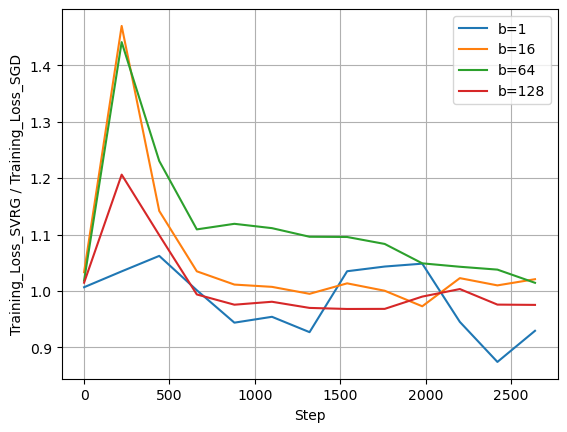

In [94]:
track = [1,16,64,128] # subset of bs, contains the batch sizes we want to plot
step_loss =  20 * np.array(list(range(150))) # we measure the train loss once in 20 steps out of 3000 total, used for x axis

ratio = True # set to true to plot the ratio of the SVRG loss and SGD loss, false to plot separately
ci = False # set to true to plot confidence interval too (when ratio is false)
for i, b in enumerate(bs):
    if b in track: # if batch size we want to plot

        if ratio:
            l, s = plot_utils.smoothen(mean_svrg[i]/mean_sgd[i], 20) # remove spikes
            plt.plot(20*s, l, label = f"b={b}")

            plt.xlabel('Step')
            plt.ylabel('Training_Loss_SVRG / Training_Loss_SGD')
        else:
            plt.plot(step_loss, mean_svrg[i], label = f"SVRG-{b}")
            if ci:
                plt.fill_between(step_loss, ci_low_svrg[i], ci_up_svrg[i], alpha = 0.3)

            plt.plot(step_loss, mean_sgd[i], label = f"SGD-{b}")
            if ci:
                plt.fill_between(step_loss, ci_low_sgd[i], ci_up_sgd[i], alpha = 0.3)
            
            plt.xlabel('Step')
            plt.ylabel('Training_Loss')

        if ratio:
            print(np.mean(mean_svrg[i][35:]/mean_sgd[i][35:])) # print mean of the ratio of the SVRG loss over SGD loss (excluding first 35 measurements)
plt.legend()
plt.grid()
plt.show()

### Variance

In [95]:
key_var = "variances" # field of interest
key_var_sgd = "variances_sgd" # field of interest

var_ratios = [] # indexed by batch size, average over runs
for i, b in enumerate(bs):
    svrg_temp = []
    sgd_temp = []
    for run in range(num_runs):
        svrg_temp.append(results_svrg[i][run][key_var])
        sgd_temp.append(results_svrg[i][run][key_var_sgd])
    var_ratios.append(np.mean(np.array(svrg_temp)[::,::,-1:].reshape([num_runs, len(svrg_temp[0])]), axis=0)/(np.mean(np.array(sgd_temp)[::,::,-1:].reshape([num_runs, len(sgd_temp[0])]), axis=0)+0.0000000001))

0.9339515538131987
0.9356086665189131
0.9505737930447532
0.9559210458957714


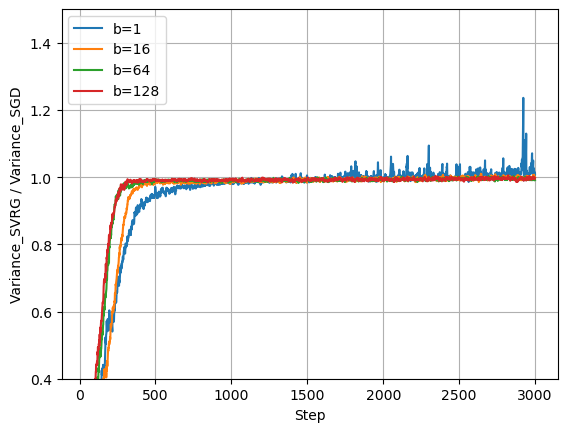

In [96]:
track = [1,16,64,128] # subset of bs, contains the batch sizes we want to plot
step_var =  np.array(list(range(3000))) # we measure the variance every step for 3000 total, used for x axis

start, end = 30, 3000 # interval of measurements to plot

smooth = False # set to true to remove spikes
for i, b in enumerate(bs):
    if b in track: # if batch size we want to plot

        if smooth:
            l, s = plot_utils.smoothen(var_ratios[i][start:end], 20) # remove spikes
            plt.plot(s, l, label = f"b={b}")
        else:
            plt.plot(step_var[start:end], var_ratios[i][start:end], label = f"b={b}")
        
        plt.ylim([0.4,1.5])
        plt.xlabel('Step')
        plt.ylabel('Variance_SVRG / Variance_SGD')

        print(np.mean(var_ratios[i][10:])) # print mean of the ratio of the SVRG loss over SGD loss (excluding first 10 measurements)
plt.legend()
plt.grid()
plt.show()

### Variance SGD alone

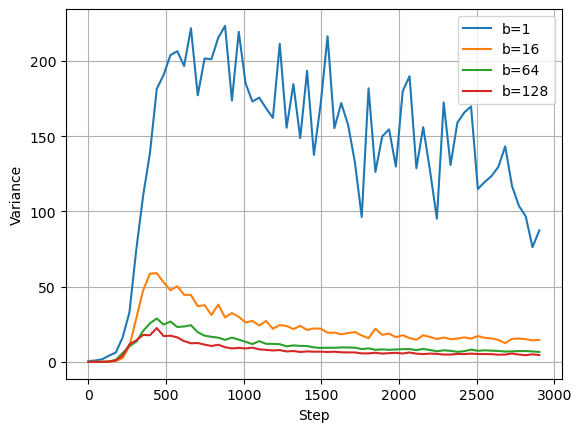

In [97]:
key_var = "variances" # field of interest

sgd = [] # indexed by batch size, average over runs
for i, b in enumerate(bs):
    sgd_temp = []
    for run in range(num_runs):
        sgd_temp.append(results_svrg[i][run][key_var])
    sgd.append(np.mean(np.array(sgd_temp)[::,::,-1:].reshape([num_runs, len(sgd_temp[0])]), axis=0))

step_var =  np.array(list(range(3000))) # we measure the variance every step for 3000 total, used for x axis

smooth = True # set to true to remove spikes
for i, b in enumerate(bs):
    if smooth:
        l, s = plot_utils.smoothen(sgd[i][start:end], 60) # remove spikes
        plt.plot(s, l, label = f"b={b}")
    else:
        plt.plot(step_var[start:end], sgd[i][start:end], label = f"b={b}")
    
    plt.xlabel('Step')
    plt.ylabel('Variance')

plt.legend()
plt.grid()
plt.show()